# makemore 5
Following a tutorial from [Andrej Karpathy](https://karpathy.ai/):
- [The spelled-out intro to language modeling: Building makemore Part 5: Building a WaveNet](https://youtu.be/t3YJ5hKiMQ0?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)

## Setup

In [2]:
# download the names.txt file from github
# !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
torch.manual_seed(42)

In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

## Starting point

In [6]:
# build the dataset
block_size = 3 # N-gram size

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
for x, y in zip(Xtr[:20], Ytr[:20]):
  print(f'{"".join(itos[ix.item()] for ix in x)} --> {itos[y.item()]}')

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [8]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update running stats
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [9]:
n_embd = 10 # number of dimensions in the embedding
n_hidden = 200

C = torch.randn((vocab_size, n_embd))
layers = [Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), Linear(n_hidden, vocab_size)]

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f'number of parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

number of parameters: 12097


In [10]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # sample a batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # gradient descent
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # metrics
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


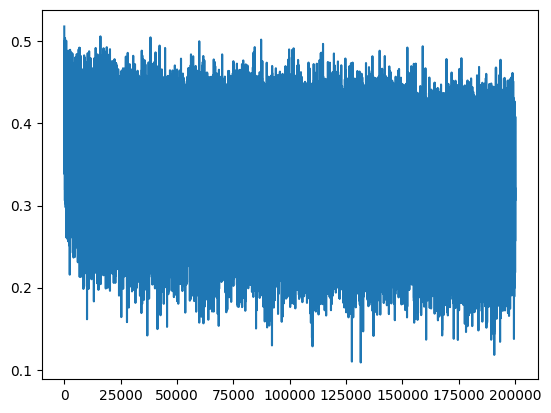

In [11]:
plt.plot(lossi)

In [12]:
# put layers into eval mode (needed for batchnorm especially)
for layer in layers:
  layer.training = False

In [13]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(f'{split} loss: {loss.item():.4f}')

split_loss('train')
split_loss('val')

train loss: 2.0583
val loss: 2.1065


In [14]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: break
    
    print(''.join(itos[i] for i in out))


damiara.
alyzah.
fard.
azalee.
sayah.
ayvi.
reino.
sophemuellani.
ciaub.
alith.
sira.
liza.
jah.
grancealynna.
jamaur.
ben.
quan.
torie.
coria.
cer.


## Improvement

In [7]:
# build the dataset
block_size = 8 # N-gram size

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [8]:
for x, y in zip(Xtr[:20], Ytr[:20]):
  print(f'{"".join(itos[ix.item()] for ix in x)} --> {itos[y.item()]}')

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [21]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update running stats
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, num_embeddings, emdedding_dim):
        self.weight = torch.randn((num_embeddings, emdedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(dim=1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [22]:
n_embd = 10 # number of dimensions in the embedding
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(f'number of parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

number of parameters: 22397


In [15]:
# we pair the embeddings 2 by 2 such that:
# the character embeddings 1, 2, 3, 4, 5, 6, 7, 8 used to be concatenated into 12345678
# but instead we want to achieve 12, 34, 56, 78
# the explicit method would be to iterate over the characters (dim=1) 2 by 2 starting at 0 and at 1 and concat the results
# the implicit method is to reshape the tensor from a (4, 8, -1) to a (4, 4, -1) which endup being equivalent
e = torch.randn(4, 8, 10)
explicit = torch.cat((e[:, ::2, :], e[:, 1::2, :]), dim=2)
(e.view(4, 4, -1) == explicit).all()

tensor(True)

In [27]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # sample a batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # gradient descent
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # metrics
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    #if i >= 999: break


      0/ 200000: 1.9832
  10000/ 200000: 2.3481
  20000/ 200000: 2.0734
  30000/ 200000: 1.9381
  40000/ 200000: 2.6235
  50000/ 200000: 2.0103
  60000/ 200000: 2.4641
  70000/ 200000: 1.6023
  80000/ 200000: 2.0687
  90000/ 200000: 1.9905
 100000/ 200000: 2.2245
 110000/ 200000: 2.5487
 120000/ 200000: 1.9948
 130000/ 200000: 2.0549
 140000/ 200000: 2.1373
 150000/ 200000: 1.8621
 160000/ 200000: 2.0851
 170000/ 200000: 1.8366
 180000/ 200000: 2.2879
 190000/ 200000: 2.0364


In [28]:
for layer in model.layers:
    print(f'{layer.__class__.__name__:<20}: {tuple(layer.out.shape)}')

Embedding           : (32, 8, 10)
FlattenConsecutive  : (32, 4, 20)
Linear              : (32, 4, 68)
BatchNorm1d         : (32, 4, 68)
Tanh                : (32, 4, 68)
FlattenConsecutive  : (32, 2, 136)
Linear              : (32, 2, 68)
BatchNorm1d         : (32, 2, 68)
Tanh                : (32, 2, 68)
FlattenConsecutive  : (32, 136)
Linear              : (32, 68)
BatchNorm1d         : (32, 68)
Tanh                : (32, 68)
Linear              : (32, 27)


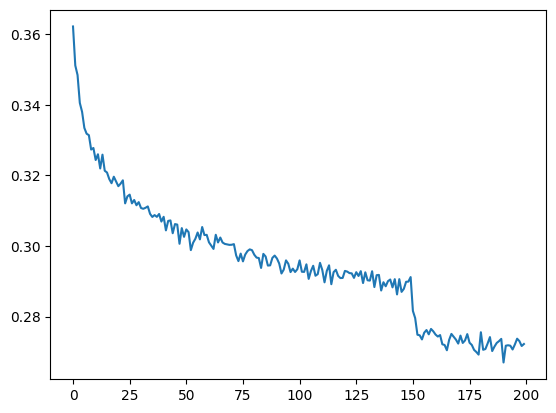

In [29]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [30]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [31]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item():.4f}')

split_loss('train')
split_loss('val')

train loss: 1.8804
val loss: 2.0353


In [32]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: break
    
    print(''.join(itos[i] for i in out))


calvion.
khylin.
jaquelj.
hilynn.
kyrie.
frudoe.
zeyiah.
olenn.
lorian.
kinsley.
will.
tykenzi.
sanolynn.
daretto.
jazkyel.
maiah.
edhyrat.
dailani.
jakelyn.
jeras.
